In [1]:
print("Kernel is working")

Kernel is working


In [2]:
import os
os.chdir("notebooks")

In [3]:
from PIL import Image
import numpy as np

def preprocess_image(image_path, target_size):
    img = Image.open(image_path)
    width, height = img.size
    if width > height:
        new_width = height
        left = (width - new_width) // 2
        right = left + new_width
        img = img.crop((left, 0, right, height))
    elif height > width:
        new_height = width
        top = (height - new_height) // 2
        bottom = top + new_height
        img = img.crop((0, top, width, bottom))
    img = img.resize(target_size)
    img_array = np.array(img)
    img_array = img_array / 255.0
    return img_array

image_dir = '../dataset/ISIC-images/'
target_size = (128, 128)
image_arrays = []

for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    img_array = preprocess_image(img_path, target_size=target_size)
    image_arrays.append(img_array)

X = np.array(image_arrays)

In [4]:
import pandas as pd

metadata = pd.read_csv('../dataset/metadata.csv')
y = metadata['diagnosis']

In [5]:
from sklearn.model_selection import train_test_split

random_state = 101
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=random_state, stratify=y_train_val)

In [6]:
classInstances = y_train.value_counts()

In [7]:
classInstances

diagnosis
nevus                         6266
pigmented benign keratosis    1084
melanoma                      1057
basal cell carcinoma           504
squamous cell carcinoma        185
vascular lesion                146
dermatofibroma                 130
actinic keratosis              121
Name: count, dtype: int64

In [8]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle

undersample_strategy = {label: 1000 for label in set(y_train) if y_train.value_counts()[label] > 1000}
undersampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train)

oversample_strategy = {label: 1000 for label in set(y_train_under) if y_train_under.value_counts()[label] < 1000}
oversampler = RandomOverSampler(sampling_strategy=oversample_strategy, random_state=42)
X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train_under, y_train_under)

X_train_balanced = X_train_balanced.reshape(-1, 128, 128, 3)
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)

In [9]:
y_train_balanced.value_counts()

diagnosis
nevus                         1000
melanoma                      1000
pigmented benign keratosis    1000
actinic keratosis             1000
vascular lesion               1000
squamous cell carcinoma       1000
basal cell carcinoma          1000
dermatofibroma                1000
Name: count, dtype: int64

In [10]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_balanced)
y_train_one_hot = to_categorical(y_train_encoded)
y_val_encoded = label_encoder.fit_transform(y_val)
y_val_one_hot = to_categorical(y_val_encoded)
y_test_encoded = label_encoder.fit_transform(y_test)
y_test_one_hot = to_categorical(y_test_encoded)

2025-10-16 16:59:39.853106: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-16 16:59:39.863614: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 16:59:40.249303: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-16 16:59:43.217715: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off,

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential()

model.add(Input(shape=(128, 128, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

datagen.fit(X_train_balanced)

history = model.fit(
    datagen.flow(X_train_balanced, y_train_one_hot, batch_size=32),
    epochs=50,
    validation_data=(X_val, y_val_one_hot),
    callbacks=[early_stopping]
)

2025-10-16 16:59:43.990509: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50


/usr/local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 154ms/step - accuracy: 0.1244 - loss: 2.0802 - val_accuracy: 0.1118 - val_loss: 2.0819
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 35s 140ms/step - accuracy: 0.1270 - loss: 2.0800 - val_accuracy: 0.1118 - val_loss: 2.0812
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - accuracy: 0.1221 - loss: 2.0819 - val_accuracy: 0.0123 - val_loss: 2.0816
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 145ms/step - accuracy: 0.1264 - loss: 2.0797 - val_accuracy: 0.0199 - val_loss: 2.0740
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - accuracy: 0.1336 - loss: 2.0754 - val_accuracy: 0.0161 - val_loss: 2.0920
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - accuracy: 0.1848 - loss: 1.9648 - val_accuracy: 0.5336 - val_loss: 1.7416
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.2026 - loss: 1.8731 - val_accuracy: 0.5090 - val_loss: 1.6193
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.2236 - loss: 1.8561 - val

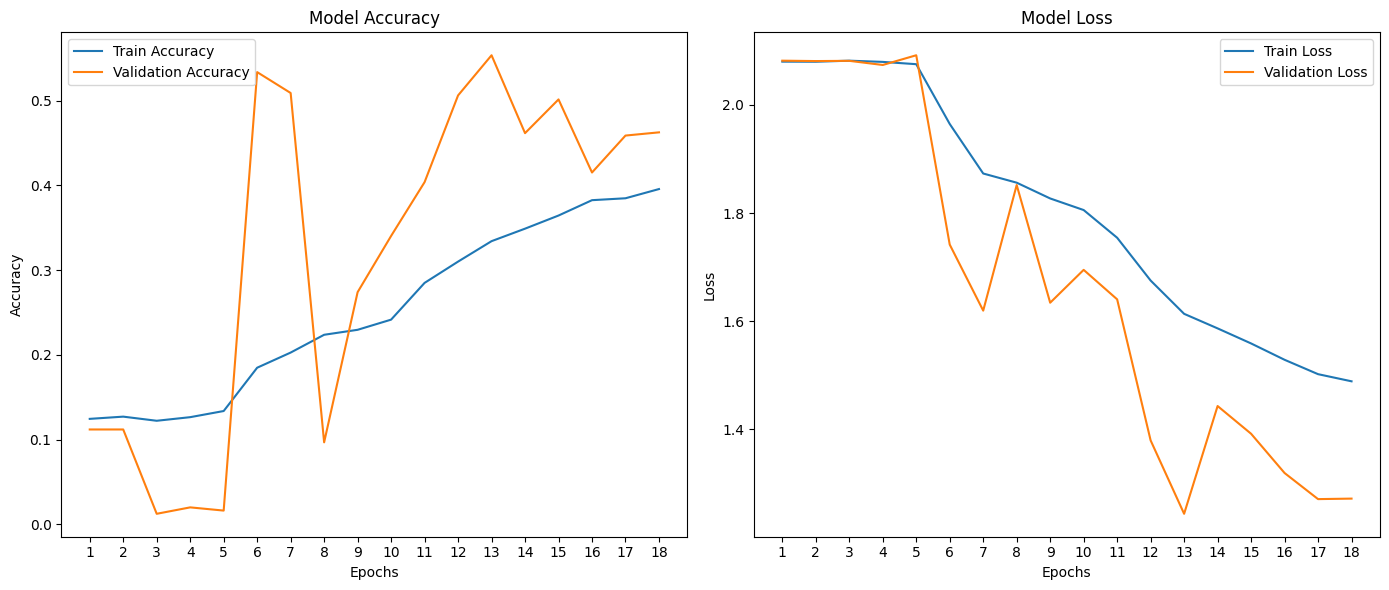

In [12]:
import matplotlib.pyplot as plt

total_epochs = len(history.history['accuracy'])
xticks_range = range(1, total_epochs + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(xticks_range, history.history['accuracy'], label='Train Accuracy')
plt.plot(xticks_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.xticks(xticks_range)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(xticks_range, history.history['loss'], label='Train Loss')
plt.plot(xticks_range, history.history['val_loss'], label='Validation Loss')
plt.xticks(xticks_range)
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step


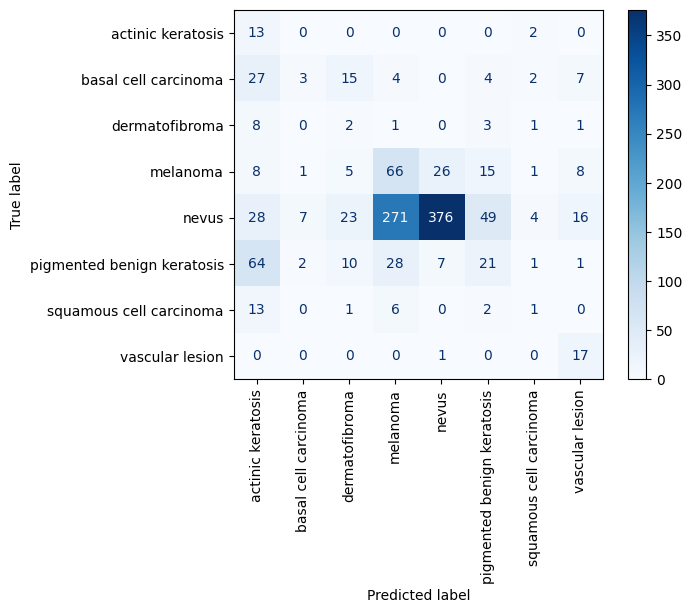

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation = 90)
plt.show()

In [14]:
X_under, y_under = undersampler.fit_resample(X.reshape(X.shape[0], -1), y)
X_balanced, y_balanced = oversampler.fit_resample(X_under.reshape(X_under.shape[0], -1), y_under)
X_balanced = X_balanced.reshape(-1, 128, 128, 3)

In [15]:
y_encoded = label_encoder.fit_transform(y_balanced)
y_one_hot = to_categorical(y_encoded)

In [16]:
model_final = Sequential()

model_final.add(Input(shape=(128, 128, 3)))
model_final.add(Conv2D(32, (3, 3), activation='relu'))
model_final.add(MaxPooling2D((2, 2)))
model_final.add(Conv2D(64, (3, 3), activation='relu'))
model_final.add(MaxPooling2D((2, 2)))
model_final.add(Conv2D(128, (3, 3), activation='relu'))
model_final.add(MaxPooling2D((2, 2)))
model_final.add(Conv2D(256, (3, 3), activation='relu'))
model_final.add(MaxPooling2D((2, 2)))

model_final.add(Flatten())
model_final.add(Dense(256, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(128, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(64, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(32, activation='relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_final.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

datagen.fit(X_balanced)

val_loss = history.history['val_loss']

optimal_total_epochs = val_loss.index(min(val_loss)) + 1

model_final.fit(datagen.flow(X_balanced, y_one_hot, batch_size=32), epochs=optimal_total_epochs)

/usr/local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 148ms/step - accuracy: 0.1759 - loss: 1.9948
Epoch 2/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.2095 - loss: 1.8901
Epoch 3/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.2247 - loss: 1.8655
Epoch 4/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.2418 - loss: 1.8218
Epoch 5/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 137ms/step - accuracy: 0.2880 - loss: 1.7480
Epoch 6/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 155ms/step - accuracy: 0.3257 - loss: 1.6661
Epoch 7/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - accuracy: 0.3554 - loss: 1.5904
Epoch 8/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 136ms/step - accuracy: 0.3832 - loss: 1.5481
Epoch 9/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 36s 144ms/step - accuracy: 0.3874 - loss: 1.5177
Epoch 10/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 34s 138ms/step - accuracy: 0.4091 - loss: 1.4913
Epoch 11/13
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 158ms/step - accuracy: 0.4190 - loss: 1.4565
Epoch 12/13
250/250

In [17]:
os.makedirs('../models', exist_ok=True)
model_final.save('../models/model.keras')

In [18]:
import json

class_names = label_encoder.classes_.tolist()
with open("../dataset/classes.json", "w") as f:
    json.dump(class_names, f)